In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from collections import Counter

from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def get_mode(row): # Кастомная функция вычисления модального значения категориального признака
    counter = Counter(row)
    (most_common, _) = counter.most_common(1)[0]

    return most_common

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
from datetime import datetime
import pytz

region_timezones = {
    'Moscow': 'Europe/Moscow',                       # +03:00
    'Moscow Oblast': 'Europe/Moscow',                # +03:00
    'St.-Petersburg': 'Europe/Moscow',               # +03:00
    'Sverdlovsk Oblast': 'Asia/Yekaterinburg',       # +05:00
    'Sverdlovsk': 'Asia/Yekaterinburg',              # +05:00
    'Krasnodar Krai': 'Europe/Moscow',               # +03:00
    'Novosibirsk Oblast': 'Asia/Novosibirsk',        # +07:00
    'Bashkortostan Republic': 'Asia/Yekaterinburg',  # +05:00
    'Samara Oblast': 'Europe/Samara',                # +04:00
    'Nizhny Novgorod Oblast': 'Europe/Moscow',       # +03:00
    'Chelyabinsk': 'Asia/Yekaterinburg',             # +05:00
    'Tatarstan Republic': 'Europe/Moscow',           # +03:00
    'Rostov': 'Europe/Moscow',                       # +03:00
    'Krasnoyarsk Krai': 'Asia/Krasnoyarsk',          # +07:00
    'Perm Krai': 'Asia/Yekaterinburg',               # +05:00
    'Leningradskaya Oblast\'': 'Europe/Moscow',      # +03:00
    'Yaroslavl Oblast': 'Europe/Moscow',             # +03:00
    'Irkutsk Oblast': 'Asia/Irkutsk',                # +08:00
    'Saratov Oblast': 'Europe/Saratov',              # +04:00
    'Voronezh Oblast': 'Europe/Moscow',              # +03:00
    'Stavropol Kray': 'Europe/Moscow',               # +03:00
    'Primorye': 'Asia/Vladivostok',                  # +10:00
    'Khabarovsk': 'Asia/Vladivostok',                # +10:00
    'Volgograd Oblast': 'Europe/Volgograd',          # +03:00
    'Amur Oblast': 'Asia/Yakutsk',                   # +09:00
    'Khanty-Mansia': 'Asia/Yekaterinburg',           # +05:00
    'Kuzbass': 'Asia/Novokuznetsk',                  # +07:00
    'Omsk Oblast': 'Asia/Omsk',                      # +06:00
    'Tula Oblast': 'Europe/Moscow',                  # +03:00
    'Udmurtiya Republic': 'Europe/Samara',           # +04:00
    'Orenburg Oblast': 'Asia/Yekaterinburg',         # +05:00
    'Altay Kray': 'Asia/Barnaul',                    # +07:00
    'Tomsk Oblast': 'Asia/Tomsk',                    # +07:00
    'Khakasiya Republic': 'Asia/Krasnoyarsk',        # +07:00
    'Vladimir Oblast': 'Europe/Moscow',              # +03:00
    'Tver Oblast': 'Europe/Moscow',                  # +03:00
    'Tyumen Oblast': 'Asia/Yekaterinburg',           # +05:00
    'Belgorod Oblast': 'Europe/Moscow',              # +03:00
    'Ryazan Oblast': 'Europe/Moscow',                # +03:00
    'Kaliningrad Oblast': 'Europe/Kaliningrad',      # +02:00
    'Ulyanovsk': 'Europe/Samara',                    # +04:00
    'Arkhangelskaya': 'Europe/Moscow',               # +03:00
    'Chuvashia': 'Europe/Moscow',                    # +03:00
    'Lipetsk Oblast': 'Europe/Moscow',               # +03:00
    'Vologda Oblast': 'Europe/Moscow',               # +03:00
    'Novgorod Oblast': 'Europe/Moscow',              # +03:00
    'Murmansk': 'Europe/Moscow',                     # +03:00
    'Smolensk Oblast': 'Europe/Moscow',              # +03:00
    'Buryatiya Republic': 'Asia/Irkutsk',            # +08:00
    'Tambov Oblast': 'Europe/Moscow',                # +03:00
    'Bryansk Oblast': 'Europe/Moscow',               # +03:00
    'Komi': 'Europe/Moscow',                         # +03:00
    'Kirov Oblast': 'Europe/Moscow',                 # +03:00
    'Kemerovo Oblast': 'Asia/Novokuznetsk',          # +07:00
    'Adygeya Republic': 'Europe/Moscow',             # +03:00
    'Sakha': 'Asia/Yakutsk',                         # +09:00
    'Kostroma Oblast': 'Europe/Moscow',              # +03:00
    'Astrakhan Oblast': 'Europe/Volgograd',          # +03:00
    'Kamchatka': 'Asia/Kamchatka',                   # +12:00
    'Sakhalin Oblast': 'Asia/Sakhalin',              # +11:00
    'Zabaykalskiy (Transbaikal) Kray': 'Asia/Chita', # +09:00
    'Yamalo-Nenets': 'Asia/Yekaterinburg',           # +05:00
    'Dagestan': 'Europe/Moscow',                     # +03:00
    'Karelia': 'Europe/Moscow',                      # +03:00
    'Pskov Oblast': 'Europe/Moscow',                 # +03:00
    'Kursk Oblast': 'Europe/Moscow',                 # +03:00
    'Kursk': 'Europe/Moscow',                        # +03:00
    'Oryol oblast': 'Europe/Moscow',                 # +03:00
    'Mordoviya Republic': 'Europe/Moscow',           # +03:00
    'Mariy-El Republic': 'Europe/Moscow',            # +03:00
    'North Ossetia–Alania': 'Europe/Moscow',         # +03:00
    'Vladimir': 'Europe/Moscow',                     # +03:00
    'Saratovskaya Oblast': 'Europe/Saratov',         # +04:00
    'Tula': 'Europe/Moscow',                         # +03:00
    'Voronezj': 'Europe/Moscow',                     # +03:00
    'Chukotka': 'Asia/Anadyr',                       # +12:00
    'Crimea': 'Europe/Simferopol',                   # +03:00
    'Kalmykiya Republic': 'Europe/Volgograd',        # +03:00
    'Tyva Republic': 'Asia/Krasnoyarsk',             # +07:00
    'Jewish Autonomous Oblast': 'Asia/Vladivostok',  # +10:00
    'Transbaikal Territory': 'Asia/Chita',           # +09:00
    'Ingushetiya Republic': 'Europe/Moscow',         # +03:00
    'Omsk': 'Asia/Omsk',                             # +06:00
    'Stavropol’ Kray': 'Europe/Moscow',              # +03:00
    'Arkhangelsk Oblast': 'Europe/Moscow',           # +03:00
    'Astrakhan': 'Europe/Volgograd',                 # +03:00
    'Penza Oblast': 'Europe/Moscow',
    'Kurgan Oblast': 'Asia/Yekaterinburg',
    'Kaluga Oblast': 'Europe/Moscow',
    'Ivanovo Oblast': 'Europe/Moscow',
    'Krasnodarskiy': 'Europe/Moscow',
    'Krasnoyarskiy Krai': 'Asia/Krasnoyarsk',  # Добавлен Красноярский край
    'Krasnoyarskiy': 'Asia/Krasnoyarsk',  # Добавлен Красноярский край
    'Chechnya': 'Europe/Moscow',
    'Karachayevo-Cherkesiya Republic': 'Europe/Moscow',
    'Magadan Oblast': 'Asia/Magadan',
    'Altai': 'Asia/Barnaul',  # Для обозначения обоих регионов
    'Ivanovo': 'Europe/Moscow',  # Иваново
    'Jaroslavl': 'Europe/Moscow',  # Ярославль (обычно "Yaroslavl" на английском)
    'Kabardino-Balkariya Republic': 'Europe/Moscow',  # Кабардино-Балкария
    'Kaliningrad': 'Europe/Kaliningrad',  # Калининград
    'Kaluga': 'Europe/Moscow',  # Калуга
    'Kirov': 'Europe/Moscow',  # Киров
    'Nenets': 'Europe/Moscow',  # Ненецкий автономный округ
    'North Ossetia': 'Europe/Moscow',  # Северная Осетия
    'Orel Oblast': 'Europe/Moscow',  # Орловская область
    'Penza': 'Europe/Moscow',  # Пенза
    'Perm': 'Asia/Yekaterinburg',  # Пермь (Пермский край)
    'Primorskiy (Maritime) Kray': 'Asia/Vladivostok',  # Приморский край
    'Sebastopol City': 'Europe/Simferopol',  # Севастополь
    'Smolensk': 'Europe/Moscow',  # Смоленск
    'Smolenskaya Oblast’': 'Europe/Moscow',  # Смоленская область
    'Stavropol Krai': 'Europe/Moscow',  # Ставропольский край
    'Tambov': 'Europe/Moscow',  # Тамбов
    'Tver’ Oblast': 'Europe/Moscow',  # Тверская область
    'Tyumen’ Oblast': 'Asia/Yekaterinburg',  # Тюменская область
    'Vologda': 'Europe/Moscow',  # Вологда
}

# Функция для перевода времени
def convert_to_local_time(row):
    # Парсим timestamp
    event_time = pd.to_datetime(row['event_timestamp'])

    # Получаем часовой пояс региона
    region_name = row['region']
    if region_name in region_timezones:
        timezone = pytz.timezone(region_timezones[region_name])
    else:
        raise ValueError(f"Unknown region: {region_name}")

    # Переводим в местное время
    local_time = event_time.astimezone(timezone)
    local_time = local_time.strftime('%Y-%m-%d %H:%M:%S')

    return local_time

In [3]:
path = './' # Ваш путь до директории с данными /path/to/data/
data = pd.read_csv(path + 'train_events.csv')
video = pd.read_csv(path + 'video_info_v2.csv')
targets = pd.read_csv(path + 'train_targets.csv')

# Предсказание социально-демографических характеристик пользователей Rutube
    Пользователи RUTUBE не всегда указывают свои данные, такие как возраст и пол, что затрудняет формирование портрета пользователя и создание персонализированных рекомендаций. Это ограничивает возможности платформы в предоставлении контента, который наиболее подходит интересам и потребностям пользователей, тем самым ухудшая пользовательский опыт.

    Необходимо разработать модель, которая на основе истории просмотров сможет предсказывать пол и возраст пользователя. В качестве baseline решения мы предоставляем этот ноутбук.


In [4]:
TRAIN_IDS, VAL_IDS = train_test_split(data['viewer_uid'].unique(), train_size=0.8, shuffle=True, random_state=11)

In [5]:
# кодировка временных данных
data['timezone'] = pd.Series(region_timezones).loc[data['region']].values
data['local_event_timestamp'] = data.apply(convert_to_local_time, 1)
data['weekday'] = pd.to_datetime(data['local_event_timestamp']).dt.weekday
data['part of day'] = pd.to_datetime(data['local_event_timestamp']).dt.hour % 6

In [26]:
# кодировка описания видео -- класстеризация
vectorizer = TfidfVectorizer(
    max_df=5e-4,
    min_df=50,
    stop_words="english",
)
X_tfidf = vectorizer.fit_transform(video.title)
print(X_tfidf.shape)
kmeans = KMeans(
    n_clusters=10000,
    max_iter=30,
    n_init=1,
    random_state=1,
).fit(X_tfidf)
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
video['cluster_id'] = kmeans.labels_

(481480, 7270)


In [173]:
events = data.merge(video, 'left')
train_events = events[events['viewer_uid'].isin(TRAIN_IDS)].merge(targets, on='viewer_uid', how='inner')
train_targets = targets[targets['viewer_uid'].isin(TRAIN_IDS)]
train_targets.loc[:, 'age_class'] = pd.cut(train_targets['age'], bins=[9, 20, 30, 40, 60], labels=[0, 1, 2, 3])
train_targets = train_targets.sort_values(by='viewer_uid').reset_index(drop=True)
val_targets = targets[targets['viewer_uid'].isin(VAL_IDS)]
val_targets.loc[:, 'age_class'] = pd.cut(val_targets['age'], bins=[9, 20, 30, 40, 60], labels=[0, 1, 2, 3])
val_targets = val_targets.sort_values(by='viewer_uid').reset_index(drop=True)

/var/folders/1j/52ghjy5x1v13yrj1b6fgwlcc0000gn/T/ipykernel_25109/1332553150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_targets.loc[:, 'age_class'] = pd.cut(train_targets['age'], bins=[9, 20, 30, 40, 60], labels=[0, 1, 2, 3])
/var/folders/1j/52ghjy5x1v13yrj1b6fgwlcc0000gn/T/ipykernel_25109/1332553150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_targets.loc[:, 'age_class'] = pd.cut(val_targets['age'], bins=[9, 20, 30, 40, 60], labels=[0, 1, 2, 3])


In [165]:
def check(predicts, *args):
    if 'age_class' not in predicts.columns:
        age_class_bins = [0, 20, 30, 40, 60] # Возрастные категории пользователей, подробнее в файле с описанием данных
        predicts['age_class'] = pd.cut(predicts['age'], bins=age_class_bins, labels=[0, 1, 2, 3])
    predicts = predicts.sort_values(by='viewer_uid').reset_index(drop=True)

    f1_weighted = f1_score(val_targets['age_class'], predicts['age_class'], average='weighted')
    accuracy = accuracy_score(val_targets['sex'], predicts['sex'])

    final_score = 0.7 * f1_weighted + 0.3 * accuracy
    print(f'Weighted F1 = {f1_weighted:.4f} \tAccuracy = {accuracy:.4f} \tFinal Score = {final_score:.4f}')

# Categorial EDA 

In [32]:
def aggregate_mode(cat):
    info = pd.DataFrame({'age': train_events.groupby(cat)['age'].median(), 'sex': train_events.groupby(cat)['sex'].apply(get_mode)})
    val_events = events[events['viewer_uid'].isin(VAL_IDS)].join(info, on=cat, how='left')
    predicts = pd.DataFrame({'age': val_events.groupby('viewer_uid')['age'].median(), 'sex': val_events.groupby('viewer_uid')['sex'].apply(get_mode)}).loc[VAL_IDS]
    predicts['sex'] = predicts['sex'].fillna(info['sex'].mode()[0])
    predicts['age'] = predicts['age'].fillna(info['age'].median())
    return predicts

In [33]:
check(aggregate_mode('cluster_id'))

Weighted F1 = 0.3354 	Accuracy = 0.6844 	Final Score = 0.4401


In [95]:
check(aggregate_mode('author_id'))

Weighted F1 = 0.3630 	Accuracy = 0.7331 	Final Score = 0.4740


In [96]:
check(aggregate_mode('category'))

Weighted F1 = 0.2205 	Accuracy = 0.6884 	Final Score = 0.3609


In [97]:
check(aggregate_mode('rutube_video_id'))

Weighted F1 = 0.3970 	Accuracy = 0.7408 	Final Score = 0.5002


In [102]:
check(aggregate_mode('timezone'))

Weighted F1 = 0.1914 	Accuracy = 0.4967 	Final Score = 0.2830


In [103]:
check(aggregate_mode('region'))

Weighted F1 = 0.1989 	Accuracy = 0.4971 	Final Score = 0.2884


In [105]:
check(aggregate_mode('ua_device_type'))

Weighted F1 = 0.1914 	Accuracy = 0.4967 	Final Score = 0.2830


In [107]:
check(aggregate_mode('ua_client_type'))

Weighted F1 = 0.1914 	Accuracy = 0.4967 	Final Score = 0.2830


In [108]:
check(aggregate_mode('ua_os'))

Weighted F1 = 0.2523 	Accuracy = 0.4990 	Final Score = 0.3263


In [109]:
check(aggregate_mode('ua_client_name'))

Weighted F1 = 0.2458 	Accuracy = 0.5278 	Final Score = 0.3304


In [111]:
check(aggregate_mode('weekday'))

Weighted F1 = 0.1914 	Accuracy = 0.4967 	Final Score = 0.2830


In [112]:
check(aggregate_mode('part of day'))

Weighted F1 = 0.1914 	Accuracy = 0.4967 	Final Score = 0.2830


categorial by mode

- yes: rutube_video_id, category, author_id, 

- mb: ua_os, ua_client_name, age stds, watchtime, watched percent, novelty

- no: ua_client_type, ua_device_type, timezone, region, weekday, part of day

# Categorial features

In [168]:
def aggregate_mode_train(cat):
    info = pd.DataFrame({'age': train_events.groupby(cat)['age'].median(), 'sex': train_events.groupby(cat)['sex'].apply(get_mode)})
    _events = events[events['viewer_uid'].isin(TRAIN_IDS)].join(info, on=cat, how='left')
    predicts = pd.DataFrame({
            cat+' age': _events.groupby('viewer_uid')['age'].median(),
            # cat+' var age': _events.groupby('viewer_uid')['age'].std(),
            cat+' sex': _events.groupby('viewer_uid')['sex'].apply(get_mode)
        }).loc[TRAIN_IDS]
    predicts[cat+' age'] = predicts[cat+' age'].fillna(info['age'].median())
    # predicts[cat+' var age'] = predicts[cat+' var age'].fillna(0)
    predicts[cat+' sex'] = predicts[cat+' sex'].fillna(info['sex'].mode()[0])
    return predicts
def aggregate_mode_val(cat):
    info = pd.DataFrame({'age': train_events.groupby(cat)['age'].median(), 'sex': train_events.groupby(cat)['sex'].apply(get_mode)})
    _events = events[events['viewer_uid'].isin(VAL_IDS)].join(info, on=cat, how='left')
    predicts = pd.DataFrame({
            cat+' age': _events.groupby('viewer_uid')['age'].median(),
            # cat+' var age': _events.groupby('viewer_uid')['age'].std(),
            cat+' sex': _events.groupby('viewer_uid')['sex'].apply(get_mode)
        }).loc[VAL_IDS]
    predicts[cat+' age'] = predicts[cat+' age'].fillna(info['age'].median())
    # predicts[cat+' var age'] = predicts[cat+' var age'].fillna(0)
    predicts[cat+' sex'] = predicts[cat+' sex'].fillna(info['sex'].mode()[0])
    return predicts

X_tr = pd.concat((
    aggregate_mode_train('cluster_id'),
    aggregate_mode_train('rutube_video_id'),
    aggregate_mode_train('category'),
    aggregate_mode_train('author_id'),
    aggregate_mode_train('ua_os'),
    aggregate_mode_train('ua_client_name'),
    ), axis=1)
X_vl = pd.concat((
    aggregate_mode_val('cluster_id'),
    aggregate_mode_val('rutube_video_id'),
    aggregate_mode_val('category'),
    aggregate_mode_val('author_id'),
    aggregate_mode_val('ua_os'),
    aggregate_mode_val('ua_client_name'),
    ), axis=1)
y_tr = targets.set_index('viewer_uid')[['sex','age']].loc[TRAIN_IDS]
lsex = LabelEncoder().fit(y_tr['sex'])
y_tr['sex'] = lsex.transform(y_tr['sex'])
y_tr['age_class'] = pd.cut(y_tr['age'], bins=[0, 20, 30, 40, 60], labels=[0, 1, 2, 3])

cf = [c+' sex' for c in ['cluster_id', 'rutube_video_id', 'category', 'author_id', 'ua_client_name', 'ua_os']] # + ['ua_client_type', 'ua_device_type']
model_sex = CatBoostClassifier(verbose=False, cat_features=cf).fit(X_tr, y_tr['sex'])
model_age = CatBoostRegressor(verbose=False, cat_features=cf).fit(X_tr, y_tr['age'])
check(pd.DataFrame({'sex': lsex.inverse_transform(model_sex.predict(X_vl)), 'age': model_age.predict(X_vl), 'viewer_uid': X_vl.index}))

Weighted F1 = 0.4153 	Accuracy = 0.7421 	Final Score = 0.5134


In [169]:
model_agec = CatBoostClassifier(1000, verbose=False, cat_features=cf).fit(X_tr, y_tr['age_class'])
check(pd.DataFrame({'sex': lsex.inverse_transform(model_sex.predict(X_vl)), 'age_class': model_agec.predict(X_vl)[:,0], 'viewer_uid': X_vl.index}), False)

Weighted F1 = 0.4557 	Accuracy = 0.7421 	Final Score = 0.5416


# Сontegeous features

In [170]:
wt = pd.Series(np.log(data.total_watchtime)).groupby(data['viewer_uid']).median()
wt.name = 'watchtime'
d = data.merge(video, 'left')
perc = pd.Series(-np.log((d.total_watchtime/d.duration))).groupby(data['viewer_uid']).median()
perc.name = 'watched_video_percent'
info = pd.to_datetime(data.event_timestamp).groupby(data.rutube_video_id).min()
dtnew = (pd.to_datetime(data.event_timestamp) - info.loc[data.rutube_video_id].reset_index(drop=True)).groupby(data['viewer_uid']).median()
dtnew.name = 'novelty_following'
md = d.duration.groupby(data['viewer_uid']).median()
md.name = 'video_duration'
data_sorted = data.sort_values(['viewer_uid','event_timestamp'])
mfr = pd.to_datetime(data_sorted.event_timestamp).diff(1).groupby(data_sorted.viewer_uid).median().dt.total_seconds().clip(0)
mfr.name = 'pause_duration'

ndf = d[['category', 'ua_os']].groupby(data['viewer_uid']).count()
ndf.columns = ['n_categories', 'n_ua_os']
tf = d[['weekday', 'part of day']].groupby(data['viewer_uid']).median()

X_tr = pd.concat((
    wt.loc[TRAIN_IDS],
    perc.loc[TRAIN_IDS],
    dtnew.loc[TRAIN_IDS],
    md.loc[TRAIN_IDS],
    mfr.loc[TRAIN_IDS],
    ndf.loc[TRAIN_IDS],
    tf.loc[TRAIN_IDS]
    ), axis=1)
X_vl = pd.concat((
    wt.loc[VAL_IDS],
    perc.loc[VAL_IDS],
    dtnew.loc[VAL_IDS],
    md.loc[VAL_IDS],
    mfr.loc[VAL_IDS],
    ndf.loc[VAL_IDS],
    tf.loc[VAL_IDS]
    ), axis=1)
y_tr = targets.set_index('viewer_uid')[['sex','age']].loc[TRAIN_IDS]
lsex = LabelEncoder().fit(y_tr['sex'])
y_tr['sex'] = lsex.transform(y_tr['sex'])
y_tr['age_class'] = pd.cut(y_tr['age'], bins=[0, 20, 30, 40, 60], labels=[0, 1, 2, 3])

model_sex = CatBoostClassifier(verbose=False).fit(X_tr, y_tr['sex'])
model_age = CatBoostRegressor(verbose=False).fit(X_tr, y_tr['age'])
check(pd.DataFrame({'sex': lsex.inverse_transform(model_sex.predict(X_vl)), 'age': model_age.predict(X_vl), 'viewer_uid': X_vl.index}))

Weighted F1 = 0.2886 	Accuracy = 0.6868 	Final Score = 0.4081


In [171]:
model_agec = CatBoostClassifier(1000, verbose=False).fit(X_tr, y_tr['age_class'])
check(pd.DataFrame({'sex': lsex.inverse_transform(model_sex.predict(X_vl)), 'age_class': model_agec.predict(X_vl)[:,0], 'viewer_uid': X_vl.index}), False)

Weighted F1 = 0.4165 	Accuracy = 0.6868 	Final Score = 0.4976


# Combined features

In [179]:
X_tr = pd.concat((
    aggregate_mode_train('cluster_id'),
    aggregate_mode_train('rutube_video_id'),
    aggregate_mode_train('category'),
    aggregate_mode_train('author_id'),
    aggregate_mode_train('ua_os'),
    aggregate_mode_train('ua_client_name'),
    wt.loc[TRAIN_IDS], perc.loc[TRAIN_IDS], dtnew.loc[TRAIN_IDS], md.loc[TRAIN_IDS], mfr.loc[TRAIN_IDS],
    ndf.loc[TRAIN_IDS], tf.loc[TRAIN_IDS]
    ), axis=1)
X_vl = pd.concat((
    aggregate_mode_val('cluster_id'),
    aggregate_mode_val('rutube_video_id'),
    aggregate_mode_val('category'),
    aggregate_mode_val('author_id'),
    aggregate_mode_val('ua_os'),
    aggregate_mode_val('ua_client_name'),
    wt.loc[VAL_IDS], perc.loc[VAL_IDS], dtnew.loc[VAL_IDS], md.loc[VAL_IDS], mfr.loc[VAL_IDS],
    ndf.loc[VAL_IDS], tf.loc[VAL_IDS]
    ), axis=1)

cf = [c+' sex' for c in ['cluster_id', 'rutube_video_id', 'category', 'author_id', 'ua_client_name', 'ua_os']]
    # + ['ua_client_type', 'ua_device_type']
for f in cf:
    X_tr[f] = lsex.transform(X_tr[f])
    X_vl[f] = lsex.transform(X_vl[f])
X_tr['novelty_following'] = X_tr['novelty_following'].dt.total_seconds()
X_vl['novelty_following'] = X_vl['novelty_following'].dt.total_seconds()

y_tr = targets.set_index('viewer_uid')[['sex','age']].loc[TRAIN_IDS]
lsex = LabelEncoder().fit(y_tr['sex'])
y_tr['sex'] = lsex.transform(y_tr['sex'])
y_tr['age_class'] = pd.cut(y_tr['age'], bins=[0, 20, 30, 40, 60], labels=[0, 1, 2, 3])

y_vl = targets.set_index('viewer_uid')[['sex','age']].loc[VAL_IDS]
y_vl['sex'] = lsex.transform(y_vl['sex'])

In [180]:
model_sex = CatBoostClassifier(1000, verbose=False, cat_features=cf).fit(X_tr, y_tr['sex'])
model_age = CatBoostRegressor(1000, verbose=False, cat_features=cf).fit(X_tr, y_tr['age'])
check(pd.DataFrame({'sex': lsex.inverse_transform(model_sex.predict(X_vl)), 'age': model_age.predict(X_vl), 'viewer_uid': X_vl.index}))

Weighted F1 = 0.4192 	Accuracy = 0.7443 	Final Score = 0.5167


In [181]:
model_agec = CatBoostClassifier(1000, verbose=False, cat_features=cf).fit(X_tr, y_tr['age_class'])
check(pd.DataFrame({'sex': lsex.inverse_transform(model_sex.predict(X_vl)), 'age_class': model_agec.predict(X_vl)[:,0], 'viewer_uid': X_vl.index}), False)

Weighted F1 = 0.4564 	Accuracy = 0.7443 	Final Score = 0.5428


# Model study

In [89]:
X_vl.columns

Index(['cluster_id age', 'cluster_id sex', 'rutube_video_id age',
       'rutube_video_id sex', 'category age', 'category sex', 'author_id age',
       'author_id sex', 'ua_os age', 'ua_os sex', 'ua_client_name age',
       'ua_client_name sex', 'watchtime', 'watched_video_percent',
       'novelty_following', 'video_duration', 'pause_duration', 'n_categories',
       'n_ua_os', 'weekday', 'part of day'],
      dtype='object')

In [143]:
imps = pd.DataFrame({'sex':model_sex.get_feature_importance(), 'age':model_agec.get_feature_importance()},
    index= #X_vl.columns)
    [
        'cluster mode age', 'cluster mode sex',
        'video mode age', 'video mode sex',
        'category mode age', 'category mode sex',
        'author mode age', 'author mode sex',
        'os mode age', 'os mode sex',
        'client mode age', 'client mode sex',
        'watched time', 'watched precent',
        'novelty checking', 'video duration', 'watching frequency',
        'number of categories', 'number of os',
        'weekday', 'daytime'
    ])
imps.loc[imps.sum(1).sort_values().index[::-1]]

,sex,age
video mode sex,35.878907,0.816932
video mode age,6.228797,30.373786
novelty checking,10.424732,10.086417
video duration,7.435317,6.740423
watched precent,4.059622,6.432531
watched time,4.415069,5.738181
author mode age,4.501832,5.095064
watching frequency,3.140341,5.578437
cluster mode age,4.443944,4.208836
number of categories,3.018928,4.044760


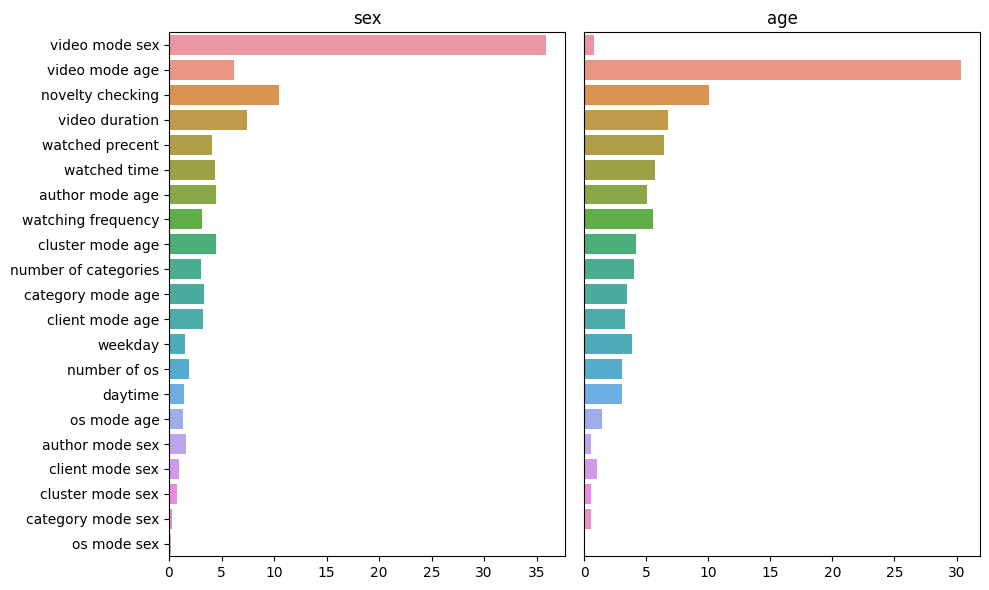

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

df = imps.loc[imps.sum(1).sort_values().index[::-1]].reset_index()
plt.figure(figsize=(10,6))
plt.subplot(121)
sns.barplot(data=df, x='sex', y='index')
plt.title('sex')
plt.ylabel('')
plt.xlabel('')
plt.subplot(122)
plt.title('age')
sns.barplot(data=df, x='age', y='index')
plt.ylabel('')
plt.xlabel('')
plt.yticks([],[])
plt.tight_layout()

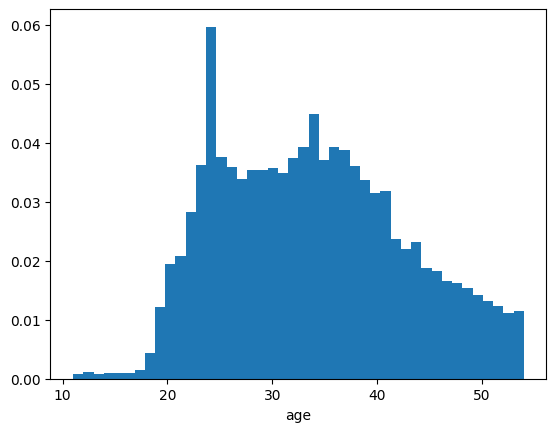

In [72]:
plt.hist(targets.age, bins=targets.age.nunique(), density=True)
plt.xlabel('age')
plt.show()

Text(0, 0.5, 'score')

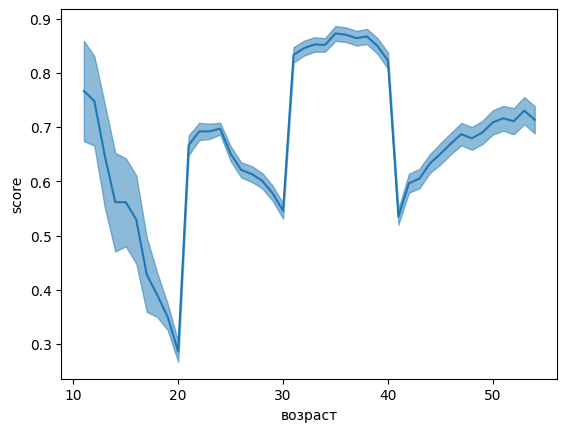

In [186]:
# train regressor
def check_plot(predicts):
    if 'age_class' not in predicts.columns:
        age_class_bins = [0, 20, 30, 40, 60] # Возрастные категории пользователей, подробнее в файле с описанием данных
        predicts['age_class'] = pd.cut(predicts['age'], bins=age_class_bins, labels=[0, 1, 2, 3])
    predicts = predicts.sort_values(by='viewer_uid').reset_index(drop=True)

    # counts = data.groupby('viewer_uid').viewer_uid.count().sort_index().reset_index(drop=True)
    counts = train_targets.age
    xs = sorted(counts.unique().tolist())
    ys = []
    err = []
    for c in xs:
        m = counts==c
        f1_weighted = f1_score(train_targets['age_class'].loc[m], predicts['age_class'].loc[m], average='weighted')
        accuracy = accuracy_score(train_targets['sex'].loc[m], predicts['sex'].loc[m])
        ys.append(0.7 * f1_weighted + 0.3 * accuracy)
        err.append(1/(m.sum())**0.5)
    return np.array(xs), np.array(ys), np.array(err)

x, y, e = check_plot(pd.DataFrame({'sex': lsex.inverse_transform(model_sex.predict(X_tr)), 'age': model_age.predict(X_tr), 'viewer_uid': X_tr.index}))

sns.lineplot(x=x, y=y)
sns.lineplot(x=x, y=(y+e).clip(0,1), lw=0)
line = sns.lineplot(x=x, y=(y-e).clip(0,1), lw=0).get_lines()
plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='tab:blue', alpha=.5)
# plt.xscale('log')
plt.xlabel('возраст')
plt.ylabel('score')

Text(0, 0.5, 'score')

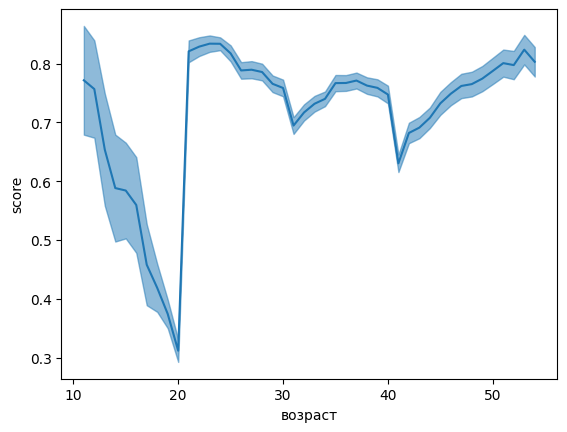

In [185]:
# train classifier
def check_plot(predicts):
    if 'age_class' not in predicts.columns:
        age_class_bins = [0, 20, 30, 40, 60] # Возрастные категории пользователей, подробнее в файле с описанием данных
        predicts['age_class'] = pd.cut(predicts['age'], bins=age_class_bins, labels=[0, 1, 2, 3])
    predicts = predicts.sort_values(by='viewer_uid').reset_index(drop=True)

    # counts = data.groupby('viewer_uid').viewer_uid.count().sort_index().reset_index(drop=True)
    counts = train_targets.age
    xs = sorted(counts.unique().tolist())
    ys = []
    err = []
    for c in xs:
        m = counts==c
        f1_weighted = f1_score(train_targets['age_class'].loc[m], predicts['age_class'].loc[m], average='weighted')
        accuracy = accuracy_score(train_targets['sex'].loc[m], predicts['sex'].loc[m])
        ys.append(0.7 * f1_weighted + 0.3 * accuracy)
        err.append(1/(m.sum())**0.5)
    return np.array(xs), np.array(ys), np.array(err)

x, y, e = check_plot(pd.DataFrame({'sex': lsex.inverse_transform(model_sex.predict(X_tr)), 'age_class': model_agec.predict(X_tr)[:,0], 'viewer_uid': X_tr.index}))

sns.lineplot(x=x, y=y)
sns.lineplot(x=x, y=(y+e).clip(0,1), lw=0)
line = sns.lineplot(x=x, y=(y-e).clip(0,1), lw=0).get_lines()
plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='tab:blue', alpha=.5)
# plt.xscale('log')
plt.xlabel('возраст')
plt.ylabel('score')

Text(0, 0.5, 'score')

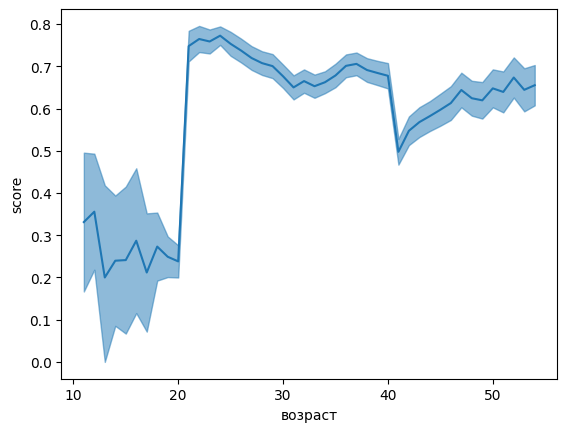

In [208]:
def check_plot(predicts):
    if 'age_class' not in predicts.columns:
        age_class_bins = [0, 20, 30, 40, 60] # Возрастные категории пользователей, подробнее в файле с описанием данных
        predicts['age_class'] = pd.cut(predicts['age'], bins=age_class_bins, labels=[0, 1, 2, 3])
    predicts = predicts.sort_values(by='viewer_uid').reset_index(drop=True)

    # counts = data.groupby('viewer_uid').viewer_uid.count().sort_index().reset_index(drop=True)
    counts = val_targets.age
    xs = sorted(counts.unique().tolist())
    ys = []
    err = []
    for c in xs:
        m = counts==c
        f1_weighted = f1_score(val_targets['age_class'].loc[m], predicts['age_class'].loc[m], average='weighted')
        accuracy = accuracy_score(val_targets['sex'].loc[m], predicts['sex'].loc[m])
        ys.append(0.7 * f1_weighted + 0.3 * accuracy)
        err.append(1/(m.sum())**0.5)
    return np.array(xs), np.array(ys), np.array(err)

x, y, e = check_plot(pd.DataFrame({'sex': lsex.inverse_transform(model_sex.predict(X_vl)), 'age_class': model_agec.predict(X_vl)[:,0], 'viewer_uid': X_vl.index}))

sns.lineplot(x=x, y=y)
sns.lineplot(x=x, y=(y+e).clip(0,1), lw=0)
line = sns.lineplot(x=x, y=(y-e).clip(0,1), lw=0).get_lines()
plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='tab:blue', alpha=.5)
# plt.xscale('log')
plt.xlabel('возраст')
plt.ylabel('score')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framewor

Text(0, 0.5, 'score')

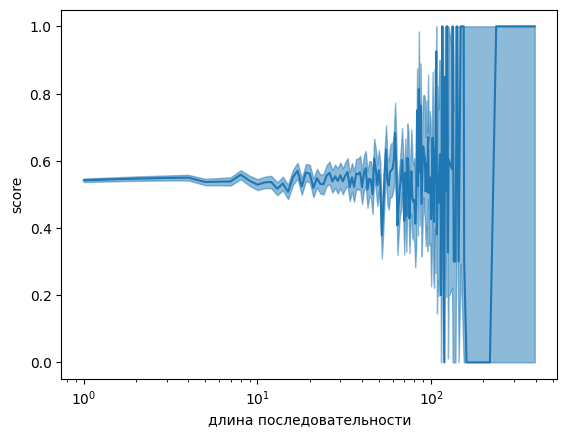

In [209]:
def check_plot(predicts):
    if 'age_class' not in predicts.columns:
        age_class_bins = [0, 20, 30, 40, 60] # Возрастные категории пользователей, подробнее в файле с описанием данных
        predicts['age_class'] = pd.cut(predicts['age'], bins=age_class_bins, labels=[0, 1, 2, 3])
    predicts = predicts.sort_values(by='viewer_uid').reset_index(drop=True)

    counts = data.groupby('viewer_uid').viewer_uid.count().sort_index().reset_index(drop=True)
    xs = sorted(counts.unique().tolist())
    ys = []
    err = []
    for c in xs:
        m = counts==c
        f1_weighted = f1_score(val_targets['age_class'].loc[m], predicts['age_class'].loc[m], average='weighted')
        accuracy = accuracy_score(val_targets['sex'].loc[m], predicts['sex'].loc[m])
        ys.append(0.7 * f1_weighted + 0.3 * accuracy)
        err.append(1/(m.sum())**0.5)
    return np.array(xs), np.array(ys), np.array(err)

x, y, e = check_plot(pd.DataFrame({'sex': lsex.inverse_transform(model_sex.predict(X_vl)), 'age_class': model_agec.predict(X_vl)[:,0], 'viewer_uid': X_vl.index}))

sns.lineplot(x=x, y=y)
sns.lineplot(x=x, y=(y+e).clip(0,1), lw=0)
line = sns.lineplot(x=x, y=(y-e).clip(0,1), lw=0).get_lines()
plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='tab:blue', alpha=.5)
plt.xscale('log')
plt.xlabel('длина последовательности')
plt.ylabel('score')

# Пример заполнения submission.csv
    Перед отправкой убедитесь, что количество уникальных пользователей в тестовой выборке и в вашей таблице предсказаний совпадает. Проверьте, чтобы в столбцах с прогнозируемыми значениями не было пропущенных значений. 

    Идентификаторы пользователей (viewer_uid) нужно сохранить как отдельную колонку, а не индекс таблицы.
    
    Не забудьте сохранить файл с параметром index = False.

In [21]:
submission = pd.DataFrame(columns=['viewer_uid', 'sex', 'age_class'])
submission['viewer_uid'] = predicts['viewer_uid'].values
submission['sex'] = predicts['sex_mode'].values
submission['age_class'] = predicts['age_class'].values

In [22]:
submission.head()

,viewer_uid,sex,age_class
0,10000001,female,2
1,10000007,male,2
2,10000010,male,2
3,10000012,male,2
4,10000014,male,2


In [ ]:
submission.to_csv(
    # path/submission.csv,
    # index=False
)